# Lambda Iterations

In [1]:
import os
import sys
import matplotlib.pyplot as plt

magritteFolder = '/home/atulits/atulit/MasterThesis/Magritte/'

sys.path.append(magritteFolder)

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
dimension = 1
npoints   = 100
nrays     = 200
nspecs    = 5
nlspecs   = 1
nquads    = 15

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-6   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]


def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)


rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


modelFile = 'vanZadelhoff_1a_1D.hdf5'
lamdaFile = f'{magritteFolder}tests/data/test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set([[r, 0, 0] for r in rs])
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

/home/atulits/atulit/MasterThesis/Magritte/src/io/python/io_python_hdf5.py:83: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with hp.File (io_file) as file:
/home/atulits/atulit/MasterThesis/Magritte/src/io/python/io_python_hdf5.py:132: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with hp.File (io_file) as file:


0

In [3]:
def max_relative_difference(a, b):
    return np.max(2.0 * np.abs((a - b) / (a + b)))

In [4]:
def Anderson_acc_gen(x , num_it, l):
    unit = np.ones(num_it-1)
    #Column vectors for U matrix but here we have row matrix
    U_transpose = []
    for i in range(0,num_it-1):
            U_transpose.append((x[i] - x[i+1]))
    U_transpose = np.array(U_transpose)       
    
    #multiply two matrix
    M = np.matmul(U_transpose, U_transpose.T, dtype = np.float32)
    
    # l is regularisation coefficient 
    M = M + l*np.identity(len(M))
    
    # inverse of U and U_T
    M = np.linalg.inv(M)
    # Normalizaton factor
    Norm = np.matmul(M,unit, dtype = np.float32)
    Norm = np.matmul(unit,Norm, dtype = np.float32)
    #coeeficients c's
    c = np.matmul(M,unit, dtype = np.float32)
    c = c/Norm
    print(sum(c))
    #np.save("c_"+str(m)+"_"+str(l))
    S_acc = 0
    for p in range(0,num_it-1):
        S_acc = S_acc + (c[p]*x[p+1])  
    return (S_acc,c)
    

In [5]:
Nmax = 100

it_diff = []
pops = []

#LTE Level population
pop  = np.copy(model.lines.lineProducingSpecies[0].population)
pops.append(pop)

#order of Anderson acc and regularization coefficient
m = 1
l = float(10**15)
Coefficients = []
#no. of itertates
#num_iterates = (m+2)

for it in range(Nmax):
    
    # Compute radiation field and resulting populations
    model.compute_radiation_field()
    model.compute_Jeff()

    if  it>=2:     
        A = []
        num_iterates = (m+2)
        for p in range(0,num_iterates):
            A.append(pops[p])
        print(len(A))
        temp = Anderson_acc_gen(A, num_iterates , l)
        
        Coefficients.append(temp[1])
        np.save(f"pops_online(and)_{it}" , temp[0])
        model.lines.lineProducingSpecies[0].population = temp[0] 
        model.lines.set_emissivity_and_opacity()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
        #pop  =  temp[0]
        m = m+1
    else:
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
    pops.append(pop)
    
    np.save(f"pops_online_{it}" , pop)
    max_diff = max_relative_difference(pops[-1], pops[-2])
    it_diff.append(max_diff)
    # Check for convergence
    if (max_diff < 1.0e-6):
        break
    print('After', it, 'iteration(s), max_diff =', max_diff)

After 0 iteration(s), max_diff = 0.6906639565036251066
After 1 iteration(s), max_diff = 1.386898356240952229
3
1.0
After 2 iteration(s), max_diff = 1.5194578337927477554
4
1.0000000298023224
After 3 iteration(s), max_diff = 1.442008136682642982
5
1.0000000298023224
After 4 iteration(s), max_diff = 1.3159452949010593761
6
0.9999999850988388
After 5 iteration(s), max_diff = 1.1936211155038236554
7
1.0000000149011612
After 6 iteration(s), max_diff = 1.0779506534533851136
8
1.0000000298023224
After 7 iteration(s), max_diff = 0.9458272499352951235
9
1.0000000074505806
After 8 iteration(s), max_diff = 0.79514234178698010906
10
1.0000000298023224
After 9 iteration(s), max_diff = 0.6240763059491291871
11
0.9999999850988388
After 10 iteration(s), max_diff = 0.44949164770386421932
12
0.9999999478459358
After 11 iteration(s), max_diff = 0.29509281147720698178
13
0.9999999850988388
After 12 iteration(s), max_diff = 0.17882932027963752112
14
1.0000000298023224
After 13 iteration(s), max_diff = 0.10

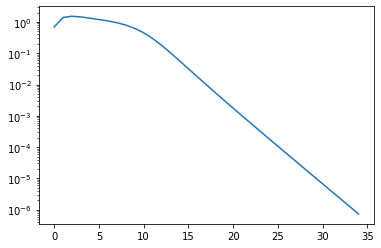

In [6]:
#a = np.load('34_order_0.npy')
plt.plot(np.arange(len(it_diff)) , it_diff)
plt.yscale("log")
plt.show()

[0.49987376 0.50012624]
[0.33321956 0.33338788 0.3333926 ]
[0.24990356 0.25002977 0.25003332 0.25003338]
[0.1999175  0.20001847 0.20002131 0.20002136 0.20002136]
[0.16659495 0.1666791  0.16668147 0.1666815  0.1666815  0.1666815 ]
[0.14279386 0.14286599 0.14286801 0.14286804 0.14286804 0.14286804
 0.14286804]
[0.12494343 0.12500654 0.12500831 0.12500834 0.12500834 0.12500834
 0.12500834 0.12500834]
[0.11106001 0.1111161  0.11111768 0.11111771 0.11111771 0.11111771
 0.11111771 0.11111771 0.11111771]
[0.09995341 0.1000039  0.10000532 0.10000534 0.10000534 0.10000534
 0.10000534 0.10000534 0.10000534 0.10000534]
[0.0908663  0.09091219 0.09091348 0.0909135  0.0909135  0.0909135
 0.0909135  0.0909135  0.0909135  0.0909135  0.0909135 ]
[0.08329377 0.08333584 0.08333702 0.08333704 0.08333704 0.08333704
 0.08333704 0.08333704 0.08333704 0.08333704 0.08333704 0.08333704]
[0.0768863  0.07692513 0.07692622 0.07692624 0.07692624 0.07692624
 0.07692624 0.07692624 0.07692624 0.07692624 0.07692624 0.0

<StemContainer object of 3 artists>

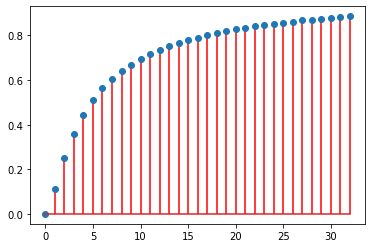

In [7]:
l_norm = []
for c in Coefficients:
    size = c[0] - np.sum(c[1:])
    l_norm.append(size**2) 
    print(c)
plt.stem(np.arange(len(l_norm)) , l_norm , 'ro')

In [8]:
a = np.load("pops_Lambda_12.npy")
b = np.load("pops_online_11.npy")

c = np.load("pops_online(and)_12.npy")
d = np.load("pops_online_12.npy")
print(-(b-c))
print(c-d)

[-1.93016099e+00  1.63213777e+00 -3.34585700e+00  3.09718784e+00
 -4.53871956e+00  4.33123119e+00 -6.04612214e+00  5.87299483e+00
 -8.00382526e+00  7.85936866e+00 -1.05558185e+01  1.04352846e+01
 -1.38654989e+01  1.37649260e+01 -1.81206395e+01  1.80367220e+01
 -2.35344239e+01  2.34644034e+01 -3.03458809e+01  3.02874562e+01
 -3.88193818e+01  3.87706325e+01 -4.92431721e+01  4.92024960e+01
 -6.19276986e+01  6.18937586e+01 -7.72058774e+01  7.71775580e+01
 -9.54317918e+01  9.54081623e+01 -1.16979148e+02  1.16959432e+02
 -1.42236041e+02  1.42219590e+02 -1.71590242e+02  1.71576515e+02
 -2.05400855e+02  2.05389402e+02 -2.43946479e+02  2.43936922e+02
 -2.87346519e+02  2.87338544e+02 -3.35456322e+02  3.35449668e+02
 -3.87749105e+02  3.87743553e+02 -4.43211265e+02  4.43206632e+02
 -5.00288559e+02  5.00284694e+02 -5.56918062e+02  5.56914837e+02
 -6.10680013e+02  6.10677322e+02 -6.59015194e+02  6.59012948e+02
 -6.99534993e+02  6.99533120e+02 -7.30286149e+02  7.30284586e+02
 -7.49953352e+02  7.49952